Simple baseline utlizing Resnet18 pretrained on ImageNet. The below results are from finetuning only the last layer. This can be set to fine tune all parameters as well. 

Below code assumes the following directory structure: <br>
<b>dseg_660</b> <br>
    |--imgs <br>
    |--labels <br>
    |--Cocos_Baseline.ipynb <br>

In [38]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import os
import copy
from PIL import *

from tqdm import tqdm_notebook as tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [39]:
# Check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); device

device(type='cuda', index=0)

In [3]:
cats = pd.read_csv('labels/categories.csv', header=None)
cats = list(cats[0])

In [8]:
data = pd.read_csv('labels/labels_train.csv')

In [9]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,000000000001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000000000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000000000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000000000005.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000000000006.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Custom Dataset Object

In [24]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transformations, train):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        # First column contains the image paths
        if train:
            self.image_arr = (self.data_info.iloc[:90000, 0])
        else:
            self.image_arr = (self.data_info.iloc[90000:, 0])
  
        self.image_arr = np.asarray(self.image_arr)
        # Second column is the labels
        if train:
            self.label_arr = np.asarray(self.data_info.iloc[:90000, 1:])
        else:
            self.label_arr = np.asarray(self.data_info.iloc[90000:, 1:])

        # Third column is for an operation indicator
        #self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.label_arr)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = Image.open(single_image_name).convert('RGB')

        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

    # Call dataset
   

In [ ]:
%cd imgs/train/

In [26]:
data_csv='../../labels/labels_train.csv'
model_name = "resnet"

In [27]:
# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model,
# when True we only update the reshaped layer params
feature_extract = True

# Number of classes
num_classes = 80

# Img model input size
im_size = 224

In [28]:
# Transformations on the data
transformations = transforms.Compose([transforms.Resize((im_size, im_size)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# Define a dictionary of dataset
# one for train and one for validation
image_datasets = {'train': CustomDatasetFromCSV(data_csv, transformations, True), 
                 'val': CustomDatasetFromCSV(data_csv, transformations, False)}

# Define data loader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

## Model

In [29]:
# Function for calculating accuracy of the model
def calc_accuracy(preds, labels):
    return (np.sum(np.around(preds.cpu().detach().numpy()) == labels.cpu().detach().numpy()))

def calc_map(preds, labels):
    preds = np.around(preds.cpu().detach().numpy())
    labels = labels.cpu().detach().numpy()             
    pred = []
    for i in preds:
        cats = np.nonzero(list(i))[0]
        pred.append(list(cats))
    label = []
    for i in labels:
        cats = np.nonzero(list(i))[0]
        label.append(list(cats))
    return metrics.mapk(label, pred)

In [30]:
import ipdb

In [31]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    ap = mAPMeter()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_mapk = 0.0
            ap.reset()
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = labels.float()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    # For multi-label
                    outputs = torch.sigmoid(outputs)
                    loss = criterion(outputs, labels)

                    preds = outputs

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                #if epoch > 0:
                #ipdb.set_trace()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += calc_accuracy(preds, labels.data)
                running_mapk += calc_map(preds, labels.data)
                ap.add(preds.cpu().detach(), labels.data.cpu().detach())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            #ipdb.set_trace()
            epoch_mapk = running_mapk / len(dataloaders[phase])
            print('{} Loss: {:.4f} Acc: {:.4f} MAP: {:.4f}'.format(phase, epoch_loss, epoch_mapk, ap.value()))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [32]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [33]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = im_size
    
    return model_ft, input_size
    
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [34]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [35]:
# Binary Cross Entropy loss function
criterion = torch.nn.BCELoss()

In [36]:
import ml_metrics as metrics
from torchnet.meter import mAPMeter

In [ ]:
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=50)

## Create Submission

In [17]:
class CustomTestDataset(Dataset):
    def __init__(self, path, transformations):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.paths = sorted(os.listdir(path))
  
        self.image_arr = np.asarray(self.paths)
        
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):
        single_image_name = "imgs/test/"+self.image_arr[index]
        # Open image
        img_as_img = Image.open(single_image_name).convert('RGB')

        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        # Get label(class) of the image based on the cropped pandas column

        return (img_as_tensor, single_image_name)

    def __len__(self):
        return self.data_len

   

In [58]:
test_dataset = CustomTestDataset('imgs/test', transformations)

In [33]:
dataloaders_dict = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size=1, 
                                                   shuffle=False, 
                                                   num_workers=4) 

In [ ]:
predictions = None
model_ft.eval()
for input_img, input_name in tqdm(dataloaders_dict):
    inputs = input_img.to(device)
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        outputs = np.around(torch.sigmoid(outputs).cpu().detach().numpy())
    try:
        predictions = np.concatenate((predictions,outputs))
    except:
        predictions = outputs


In [32]:
labels = []
for x in predictions:
    a = np.nonzero(x)[0]
    b = " ".join(map(str, a))
    labels.append(b)
    

In [33]:
submission = pd.DataFrame(
    {'id': test_dataset.paths,
     'predictions': labels
    })

In [63]:
df.to_csv('../../sample_submission.csv', index=False)

## Evaluation

In [29]:
# cd to the directory containing your image
%cd /home/hbku/my_img/

/home/hbku1/ml


In [30]:
# Load your image and preprocess it
sample_img = Image.open('serve-trophy.jpg').convert('RGB')
img_tensor = transformations(sample_img)
img_tensor = img_tensor.reshape(1, 3, 224, 224)

In [31]:
# Set model to evaluation mode
model_ft.eval()
with torch.no_grad():
    img_tensor_tensor = img_tensor.to(device)
    outputs = model_ft(img_tensor_tensor)
    outputs = torch.sigmoid(outputs)
    preds = np.around(outputs.cpu().detach().numpy())

In [32]:
# Get categories classified as true
cats_list = [cats[i] for i, x in enumerate(list(preds.squeeze())) if x == 1]

['person']


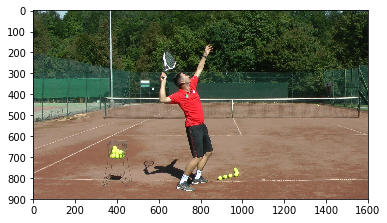

In [33]:
from matplotlib.pyplot import imshow
imshow(np.asarray(sample_img))
print(cats_list)